# Stat-Win Classification analysis: Hero stat

> by Imt of NYXL (imt@andbox.com)

# Data Preparation

In [1]:
import os
import pandas as pd 
from tqdm import tqdm
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats

## 0. Preprocess simple PHS files

> define `is_all_time` == True or False

> if `is_all_time` == False, then specify `phs_name = phs_list[#]`

> add `is_match_winner` and `is_map_winner` features into the dataframe

In [2]:
# File path of prepared new_phs
path = "./data/"
phs_list = os.listdir(path)
phs_list = [file_name for file_name in phs_list if file_name.endswith(".csv")]

# choose all time or specific season
is_all_time = False # set True if target data is all seasons data

if is_all_time == True:
    li = []
    for phs_name in phs_list:
        new_phs = pd.read_csv(f'{path}{phs_name}')
        li.append(new_phs)
    new_phs = pd.concat(li, axis=0, ignore_index=True)
    all_seasons = True

else:
    phs_name = phs_list[11] # set index of target csv file
    print(f'selected phs: {phs_name}')
    new_phs = pd.read_csv(f'{path}{phs_name}')
    all_seasons = False

# Add 'is_match_winner' feature
def match_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0
    '''
    if df['match_winner'] == df['team_name']: #there's 'team' column in 2018 data 
        return 1
    elif df['match_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_match_winner'] = new_phs.apply(match_winner, axis = 1)

# Add 'is_map_winner' feature
def map_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0; draw = -1
    '''
    if df['map_winner'] == df['team_name']:
        return 1
    elif df['map_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_map_winner'] = new_phs.apply(map_winner, axis = 1)

selected phs: new_phs_2020_2.csv


Text(0.5, 0, 'Time Played (s) / Map')

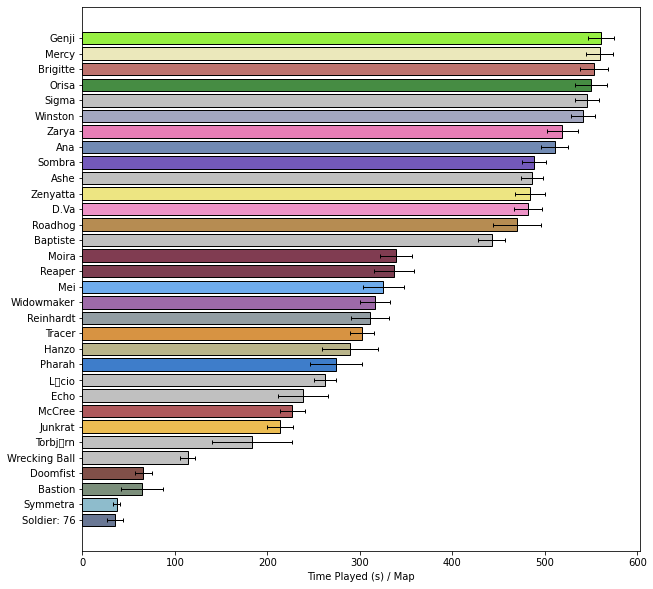

In [3]:
# absolute hero play time
df_abs_hpt = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'is_map_winner']]
df_abs_hpt = df_abs_hpt[df_abs_hpt['stat_name'] == 'Time Played']

df_abs_hpt = df_abs_hpt.drop(df_abs_hpt[df_abs_hpt['hero_name']=='All Heroes'].index)
df_abs_hpt = df_abs_hpt.groupby(['hero_name'])['stat_amount'].agg(['mean', 'std', 'count', 'sem'])

df_abs_hpt.sort_values(by=['mean'], inplace=True)

# plot data
hero_hex_color = {'Ana':'#718ab3', 'Bastion':'#7c8f7b', 'Brigitte':'#be736e', 'D.Va':'#ed93c7', 'Doomfist':'#815049', 'Genji':'#97ef43', 'Hanzo':'#b9b48a', 'Junkrat':'#ecbd53', 'Lúcio':'#85c952', 'McCree':'#ae595c', 'Mei':'#6faced', 'Mercy':'#ebe8bb', 'Moira':'#803c51', 'Orisa':'#468c43', 'Pharah':'#3e7dca', 'Reaper':'#7d3e51', 'Reinhardt':'#929da3', 'Roadhog':'#b68c52', 'Soldier: 76':'#697794', 'Sombra':'#7359ba', 'Symmetra':'#8ebccc', 'Torbjörn':'#c0726e', 'Tracer':'#d79342', 'Widowmaker':'#9e6aa8', 'Winston':'#a2a6bf', 'Zarya':'#e77eb6', 'Zenyatta':'#ede582'}

color = df_abs_hpt.index.map(hero_hex_color)
color = color.fillna('#C0C0C0')

plt.figure(figsize=(10,10))
plt.barh(df_abs_hpt.index.values, df_abs_hpt['mean'], color=color, edgecolor='black', linewidth=1, xerr=df_abs_hpt['sem'], error_kw={'ecolor':'black', 'elinewidth':1, 'capsize':2})
plt.xlabel('Time Played (s) / Map')

## 1. Feature Engineering

> define a `target_hero` = <hero name>

> remove features of `remove_feature`

> specify the data type `X, y = data_type[#]` among 0:'real', 1:'norm' or 2:'10min avg' ...

In [78]:
# select targets
# Team
target_team = 'All' 
'''
'Houston Outlaws' 'Paris Eternal' 'Los Angeles Gladiators'
 'New York Excelsior' 'Guangzhou Charge' 'Philadelphia Fusion'
 'Shanghai Dragons' 'Vancouver Titans' 'Toronto Defiant'
 'Washington Justice' 'Dallas Fuel' 'London Spitfire'
 'San Francisco Shock' 'Seoul Dynasty' 'Chengdu Hunters'
 'Los Angeles Valiant' 'Boston Uprising' 'Atlanta Reign' 'Hangzhou Spark'
 'Florida Mayhem'
'''

# Player
target_player = 'All'

# Hero
target_hero = 'Orisa'
'''
'All Heroes' 'Orisa' 'Winston' 'L첬cio' 'Mercy' 'Hanzo' 'Junkrat' 'Tracer'
 'Roadhog' 'Soldier: 76' 'Zenyatta' 'D.Va' 'Widowmaker' 'Zarya'
 'Reinhardt' 'McCree' 'Pharah' 'Brigitte' 'Genji' 'Sombra' 'Reaper'
 'Doomfist' 'Bastion' 'Mei' 'Moira' 'Torbj철rn' 'Ana' 'Symmetra' 'Sigma'
 'Baptiste' 'Wrecking Ball' 'Ashe' 'Echo'
'''

# data collection
df = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'is_map_winner']]

# data selection
if target_team != 'All':
    df = df[df['team_name'] == target_team]

if target_player != 'All':
    df = df[df['player_name'] == target_player]

if target_hero != 'All':
    df = df[df['hero_name'] == target_hero]
else:
    target_hero = 'All Heroes'
    df = df[df['hero_name'] == target_hero]

df['is_map_winner'].dropna(axis=0, inplace=True) # drop nan values
df.drop(df[df['is_map_winner'] == -1].index , inplace=True) # drop draw

df = df.groupby(['esports_match_id', 'player_name', 'is_map_winner', 'map_name', 'stat_name'])[['stat_amount', 'is_map_winner']].mean()
df = df.unstack()

df = df.xs('stat_amount', level=0, axis=1)

# Remove irrelevant features
remove_feature = ['Average Time Alive', 'Damage Done', 'Knockback Kills', 'Teleporter Pads Destroyed', 'Time Alive', 'Turrets Destroyed', 'Ultimates Earned - Fractional'] # remove features seems to be irrelevant

common_stats = ['Deaths', 'Final Blows', 'Objective Time', 'Assists', 'Objective Kills', 'All Damage Done', 'Melee Percentage of Final Blows', 'Hero Damage Done', 'Melee Final Blows', 'Ultimates Used', 'Healing Done', 'Defensive Assists', 'Barrier Damage Done', 'Shots Fired', 'Weapon Accuracy', 'Multikills', 'Time Building Ultimate', 'Solo Kills', 'Time Holding Ultimate', 'Damage Blocked', 'Damage - Quick Melee', 'Time Elapsed per Ultimate Earned', 'Offensive Assists', 'Environmental Kills', 'Environmental Deaths', 'Recon Assists', 'Eliminations', 'Damage Taken'] # Stats of 'All Heroes'

remove_feature.extend(common_stats) # remove features seems to be irrelevant or redundant
df = df[df.columns.difference(remove_feature)]

# Data cleansing
df.fillna(0, inplace=True)
df = df.stack()
df = df.groupby(['esports_match_id', 'is_map_winner', 'map_name', 'stat_name']).mean()
df = df.unstack()

# check nan values in df
print(f'nan values in df: {df.isnull().sum().sum()}')
display(df.head()) # combined dataframe

# normalize to 10 min average
df_10min = df[df.columns.difference(['is_map_winner'])].div(df['Time Played'], axis=0)
df_10min = df_10min * 600 # 10 min avg
df_10min = df_10min.dropna(axis=0) # cleansing nan values

print(f'num nan values in df_10min: {df_10min.isnull().sum().sum()}')
display(df_10min)

df_10min_0 = df_10min.xs(0, level=1)
df_10min_1 = df_10min.xs(1, level=1)

df_10min_0['is_map_winner'] = 0
df_10min_1['is_map_winner'] = 1

df_10min = pd.concat([df_10min_0, df_10min_1])

# Data transform
X_10min = df_10min.drop(['is_map_winner'], axis=1)
y_10min = df_10min['is_map_winner']

# Select X, y data type
'''
0: 10min
'''
# save data type here
data_type = []
data_type.append([X_10min, y_10min])

X, y = data_type[0] # select data type with index

nan values in df: 0


stat_name                                     Critical Hit Kills  \
esports_match_id is_map_winner map_name                            
34713            0             Havana                        1.0   
                               King's Row                    0.0   
                               Lijiang Tower                 1.0   
                 1             Havana                        1.0   
                               Lijiang Tower                 1.0   

stat_name                                     Damage - Weapon  \
esports_match_id is_map_winner map_name                         
34713            0             Havana             5135.051060   
                               King's Row         1015.500000   
                               Lijiang Tower      1503.600023   
                 1             Havana             2956.028404   
                               Lijiang Tower      2275.452274   

stat_name                                     Damage Amplified  \
esports_match_id is_map_winner map_name                          
34713            0             Havana              2884.491399   
                               King's Row           421.771276   
                               Lijiang Tower       1228.878763   
                 1             Havana              1578.728550   
                               Lijiang Tower       2247.208971   

stat_name                                     Healing Received  \
esports_match_id is_map_winner map_name                          
34713            0             Havana              5478.134775   
                               King's Row          1336.292625   
                               Lijiang Tower       1767.874935   
                 1             Havana              3369.690358   
                               Lijiang Tower       3411.578476   

stat_name                                     Players Halted  \
esports_match_id is_map_winner map_name                        
34713            0             Havana                   38.0   
                               King's Row                8.0   
                               Lijiang Tower            16.0   
                 1             Havana                   25.0   
                               Lijiang Tower            22.0   

stat_name                                     Quick Melee Accuracy  \
esports_match_id is_map_winner map_name                              
34713            0             Havana                     0.200000   
                               King's Row                 0.000000   
                               Lijiang Tower              0.222222   
                 1             Havana                     0.090909   
                               Lijiang Tower              0.500000   

stat_name                                     Quick Melee Hits  \
esports_match_id is_map_winner map_name                          
34713            0             Havana                      2.0   
                               King's Row                  0.0   
                               Lijiang Tower               2.0   
                 1             Havana                      1.0   
                               Lijiang Tower               3.0   

stat_name                                     Quick Melee Ticks  Shots Hit  \
esports_match_id is_map_winner map_name                                      
34713            0             Havana                      10.0      480.0   
                               King's Row                   3.0      116.0   
                               Lijiang Tower                9.0      238.0   
                 1             Havana                      11.0      299.0   
                               Lijiang Tower                6.0      244.0   

stat_name                                     Shots Missed  \
esports_match_id is_map_winner map_name                      
34713            0             Havana               1417.0   
     

num nan values in df_10min: 0


stat_name                                     Critical Hit Kills  \
esports_match_id is_map_winner map_name                            
34713            0             Havana                   1.265680   
                               King's Row               0.000000   
                               Lijiang Tower            3.007774   
                 1             Havana                   1.712264   
                               Lijiang Tower            2.764964   
...                                                          ...   
34917            0             Lijiang Tower            0.000000   
35521            0             Oasis                    0.000000   
35524            0             Busan                    0.000000   
35532            0             Havana                   0.000000   
35552            0             Hollywood                0.000000   

stat_name                                     Damage - Weapon  \
esports_match_id is_map_winner map_name                         
34713            0             Havana             6499.329192   
                               King's Row         4777.809432   
                               Lijiang Tower      4522.489516   
                 1             Havana             5061.501526   
                               Lijiang Tower      6291.542944   
...                                                       ...   
34917            0             Lijiang Tower      6545.436162   
35521            0             Oasis                 0.000000   
35524            0             Busan                 0.000000   
35532            0             Havana             4879.143271   
35552            0             Hollywood             0.000000   

stat_name                                     Damage Amplified  \
esports_match_id is_map_winner map_name                          
34713            0             Havana              3650.841819   
                               King's Row          1984.384817   
                               Lijiang Tower       3696.189968   
                 1             Havana              2703.200333   
                               Lijiang Tower       6213.451236   
...                                                        ...   
34917            0             Lijiang Tower       2301.625325   
35521            0             Oasis                  0.000000   
35524            0             Busan                  0.000000   
35532            0             Havana              3520.874354   
35552            0             Hollywood              0.000000   

stat_name                                     Healing Received  \
esports_match_id is_map_winner map_name                          
34713            0             Havana              6933.563240   
                               King's Row          6287.101436   
                               Lijiang Tower       5317.368806   
                 1             Havana              5769.800070   
                               Lijiang Tower       9432.890653   
...                                                        ...   
34917            0             Lijiang Tower       4650.765715   
35521            0             Oasis                  0.000000   
35524            0             Busan                  0.000000   
35532            0             Havana              5723.798509   
35552            0             Hollywood              0.000000   

stat_name                                     Players Halted  \
esports_match_id is_map_winner map_name                        
34713            0             Havana              48.095823   
                               King's Row          37.639070   
                               Lijiang Tower       48.124389   
                 1             Havana              42.806604   
                               Lijiang Tower       60.829201   
...                                                      ...   
34917            0             Lijiang 

## 2. Analyze stats between map winner vs. loser

> Compare stat between winner team vs loser team and show significantly different stats

> Plot the normalized stat amounts in bar graph, and color red if the stat's p-value < 0.05

> Results (csv and png files) will be saved into './result/`target_hero`/'

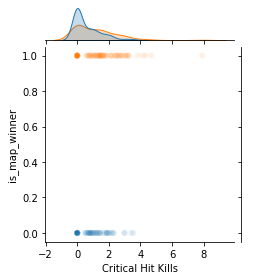

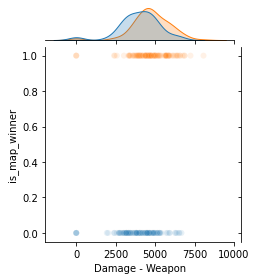

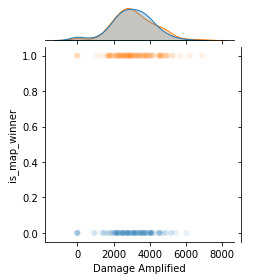

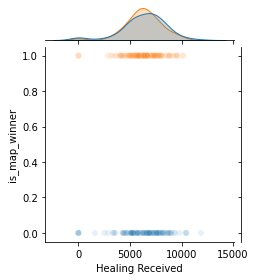

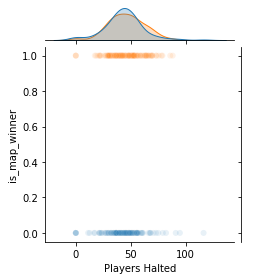

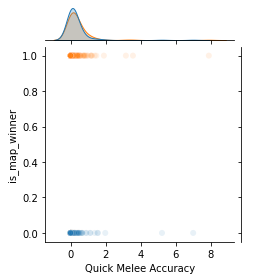

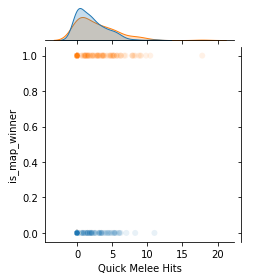

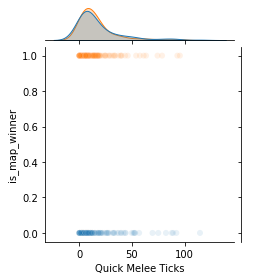

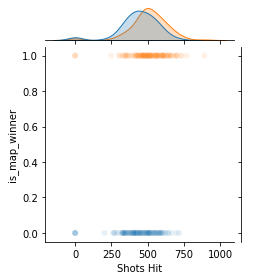

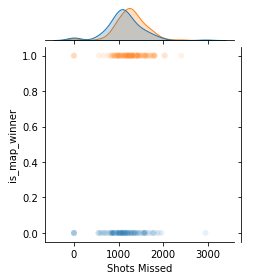

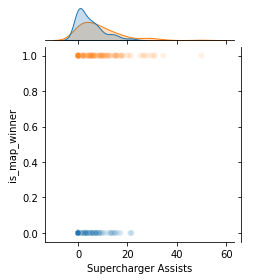

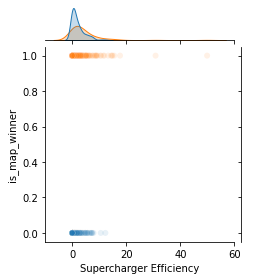

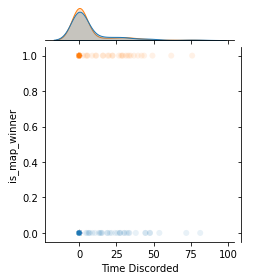

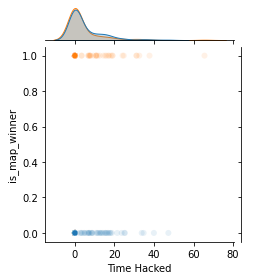

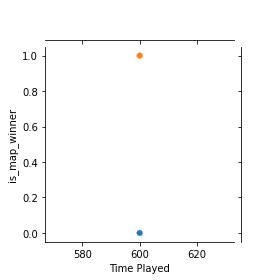

In [79]:
for f in X.columns:
    sns.jointplot(x=X[f], y=y, hue=y, height=4, legend=False, alpha=0.1)

# Data Modeling

In [80]:
# Import pakages for machine learning

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Dense

## 1. Logistic Regression

(206, 15) (52, 15) (206,) (52,)
Accuracy: 0.77


,cols,abs_coef
14,Time Played,0.000000
11,Supercharger Efficiency,0.004176
2,Damage Amplified,0.104804
5,Quick Melee Accuracy,0.122092
9,Shots Missed,0.146063


Text(0.23785130244697247, 0, 'accuracy: 0.77')

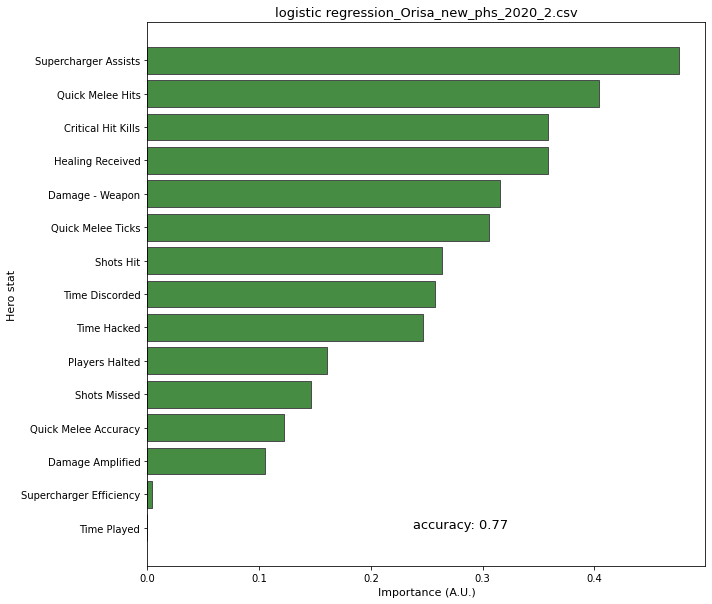

In [92]:
# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create the logistic regression model
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)

# Accuracy
accuracy = log.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# Get feature coefficient
coef = log.coef_[0]
# abs_coef = coef
abs_coef = abs(coef)

# summarize feature coefficient
fea_rank_ = pd.DataFrame({'cols': feature_names, 'abs_coef': abs_coef})
fea_rank_.sort_values(by=['abs_coef'], ascending = True, inplace=True)

display(fea_rank_.head())

# Plot feature coefficient
if all_seasons == True:
    title = f'logistic regression_{target_hero}_all seasons'
else:
    title = f'logistic regression_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['abs_coef'], facecolor=hero_hex_color.get(target_hero), alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Hero stat', fontsize=11)
plt.xlabel('Importance (A.U.)', fontsize=11)

plt.text(x=max(fea_rank_['abs_coef'])/2, y=min(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

Accuracy: 0.60
[ True  True  True False False False False False False False False  True
 False  True False]


Text(5.5, 14, 'accuracy: 0.60')

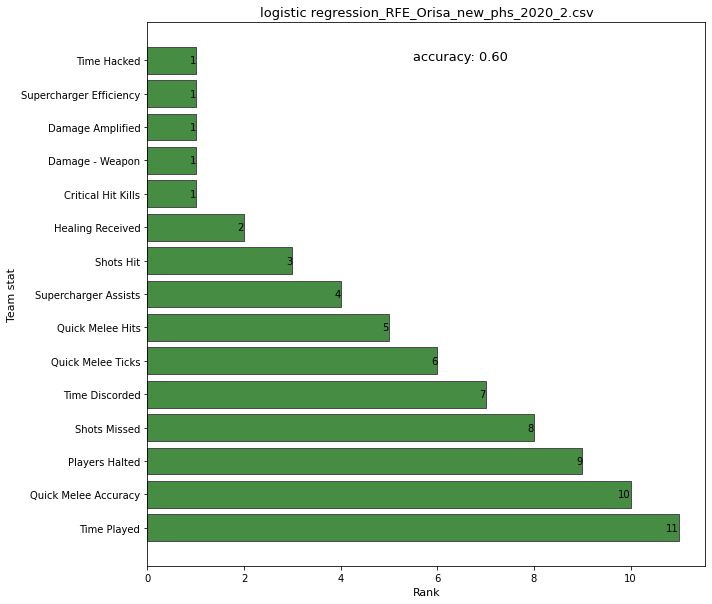

In [82]:
#Recursive Feature Elimination(RFE)

# create the RFE model
rfe = RFE(estimator=log, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

# Accuracy
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols': feature_names, 'fea_rank': rfe.ranking_})
fea_rank_ = fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending=False)

# Plot feature importance
if all_seasons == True:
    title = f'logistic regression_RFE_{target_hero}_all seasons'
else:
    title = f'logistic regression_RFE_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['fea_rank'], facecolor=hero_hex_color.get(target_hero), alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Rank', fontsize=11)

for i in fea_rank_.index: # add values on bar graph
   plt.text(fea_rank_.loc[i, 'fea_rank'], fea_rank_.loc[i, 'cols'], fea_rank_.loc[i, 'fea_rank'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_rank_['fea_rank'])/2, y=max(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

## 2. LightGBM classification

(164, 15) (52, 15) (164,) (52,)
[LightGBM] [Warning] num_iterations is set=5000, num_boost_round=5000 will be ignored. Current value: num_iterations=5000
Accuracy: 0.63


Text(480.5, 0, 'accuracy: 0.63')

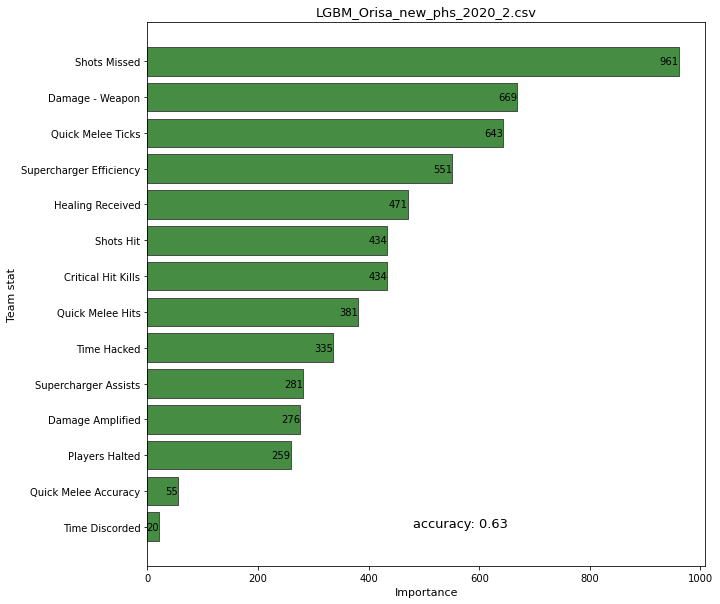

In [83]:
# LightGBM 
'''
note: https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
'''
# set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) # validation set

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create the lightGBM model
lgbm = lgb.LGBMClassifier(
   objective='binary', 
   boosting_type='gbdt', # gbdt(gradient boosting decision tree), rf(random forest), dart(dropouts meet multiple additive regression trees), goss(Gradient-based One-Side Sampling)
   learning_rate=0.001,
   n_estimators=500,
   num_boost_round=5000,
   )

lgbm.fit(
   X_train, y_train,
   eval_metric='binary_logloss',
   eval_set=(X_val, y_val),
   early_stopping_rounds=1000,
   verbose=False
   )

lgbm.booster_.feature_importance()

# Accuracy
accuracy = lgbm.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols': feature_names, 'fea_imp': lgbm.feature_importances_})
fea_imp_ = fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending=True)

# Plot feature importance
if all_seasons == True:
    title = f'LGBM_{target_hero}_all seasons'
else:
    title = f'LGBM_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_imp_['cols'], fea_imp_['fea_imp'], facecolor=hero_hex_color.get(target_hero), alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)
for i in fea_imp_.index: # add values on bar graph
   plt.text(fea_imp_.loc[i, 'fea_imp'], fea_imp_.loc[i, 'cols'], fea_imp_.loc[i, 'fea_imp'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_imp_['fea_imp'])/2, y=min(fea_imp_.index), s=f'accuracy: {accuracy}', fontsize=13)

## Learning with reduced features

In [84]:
# reduce features
sel_features = fea_rank_[fea_rank_['fea_rank'] == 1]['cols']
sel_X = X[sel_features]
sel_y = y

(206, 5) (52, 5) (206,) (52,)
Accuracy: 0.73


,cols,abs_coef
0,Critical Hit Kills,0.331656
4,Time Hacked,0.401009
2,Damage Amplified,0.435095
3,Supercharger Efficiency,0.680932
1,Damage - Weapon,0.694506


Text(0.34725307274352846, 0, 'accuracy: 0.73')

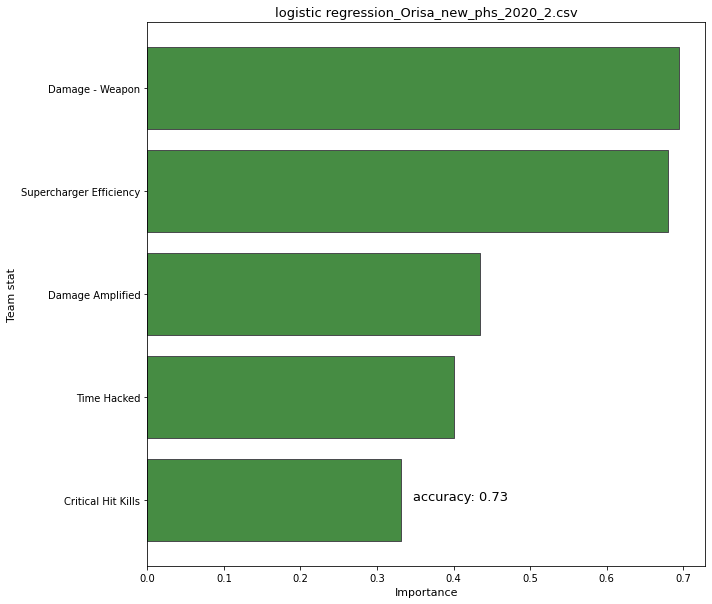

In [85]:
# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(sel_X, sel_y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create the logistic regression model
log = LogisticRegression()
log.fit(X_train, y_train)

# Accuracy
accuracy = log.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# Get feature coefficient
coef = log.coef_[0]
# abs_coef = coef
abs_coef = abs(coef)

# summarize feature coefficient
fea_rank_ = pd.DataFrame({'cols': feature_names, 'abs_coef': abs_coef})
fea_rank_.sort_values(by=['abs_coef'], ascending = True, inplace=True)

display(fea_rank_.head())

# Plot feature coefficient
if all_seasons == True:
    title = f'logistic regression_{target_hero}_all seasons'
else:
    title = f'logistic regression_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['abs_coef'], facecolor=hero_hex_color.get(target_hero), alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)

plt.text(x=max(fea_rank_['abs_coef'])/2, y=min(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

In [86]:
import shap

shap.initjs()

explainer = shap.LinearExplainer(log, X_train) # feature_perturbation='correlation_dependent'
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)
shap_values.shape

(52, 5)

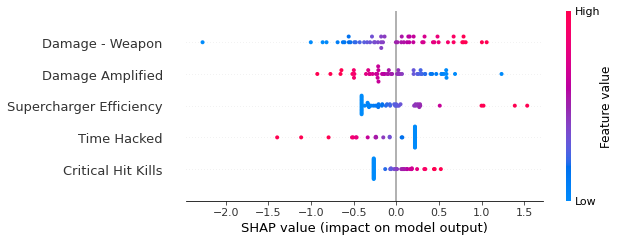

In [87]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

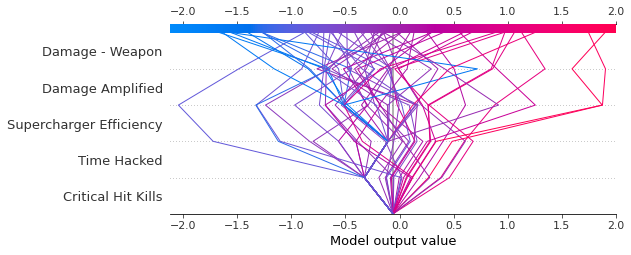

In [88]:
shap.decision_plot(expected_value, shap_values, feature_names)

## Player's stat ranking

In [89]:
# player evaluation - stat ranking
target_stat = "Weapon Kills"

df_player_stat = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount']]
df_player_stat = df_player_stat[df_player_stat['hero_name'] == target_hero]
# df_player_stat_pt = df_player_stat[df_player_stat['stat_name'] == 'Time Played']
# df_player_stat = df_player_stat[df_player_stat['stat_name'] == target_stat]

df_player_stat = df_player_stat.groupby(['player_name', 'stat_name'])['stat_amount'].sum()
df_player_stat = df_player_stat.unstack()

df_player_stat_time_played = df_player_stat['Time Played'] # save hero time played as series

df_player_stat = df_player_stat[target_stat] # get selected feature
df_player_stat = pd.concat([df_player_stat, df_player_stat_time_played], axis=1)
df_player_stat.dropna(inplace=True)
df_player_stat[f'{target_stat}/10min'] = df_player_stat[target_stat].div(df_player_stat['Time Played'], axis=0) * 600

df_player_stat.sort_values(target_stat, inplace=True)

df_player_stat = df_player_stat.round(decimals=2)

plt.figure(figsize=(18,10))
plt.barh(df_player_stat.index.values, df_player_stat[target_stat], color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1, )
plt.ylabel('players')
plt.xlabel(f'Total {target_stat}')
for i in df_player_stat.index: # add values on bar graph
   plt.text(df_player_stat.loc[i, target_stat]+1, i, df_player_stat.loc[i, target_stat], 
   horizontalalignment='left', 
   verticalalignment='center')

KeyError: 'Weapon Kills'

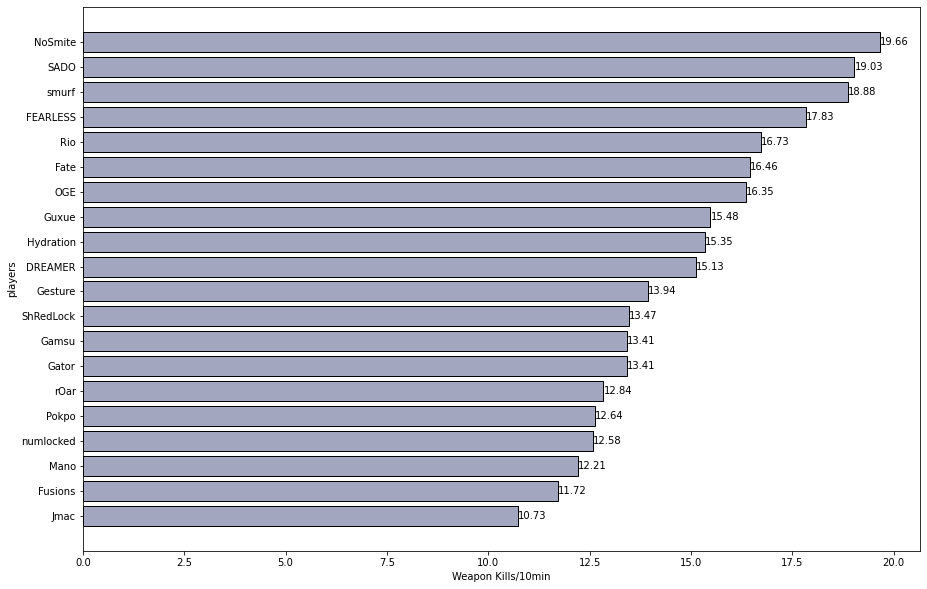

In [77]:
# for 10min stat
cut_time = 3600 # remove players who played less than cut_time
df_player_stat = df_player_stat[df_player_stat['Time Played'] >= cut_time]
df_player_stat.sort_values(f'{target_stat}/10min', inplace=True)

plt.figure(figsize=(15,10))
plt.barh(df_player_stat.index.values, df_player_stat[f'{target_stat}/10min'], color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1, )
plt.ylabel('players')
plt.xlabel(f'{target_stat}/10min')
for i in df_player_stat.index: # add values on bar graph
   plt.text(df_player_stat.loc[i, f'{target_stat}/10min'], i, df_player_stat.loc[i, f'{target_stat}/10min'], 
   horizontalalignment='left', 
   verticalalignment='center')